In [182]:
%matplotlib inline
import numpy as np 
import pandas as pd 
from scipy import stats as ss
from sklearn import metrics
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (30.0, 15.0)


In [202]:
!pip install sklearn
!pip install bayesian-optimization
!pip install scikit-optimize
!pip install shap

  Stored in directory: /Users/cng/Library/Caches/pip/wheels/1d/0d/3b/6b9d4477a34b3905f246ff4e7acf6aafd4cc9b77d473629b77
Successfully built bayesian-optimization


In [ ]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from bayes_opt import BayesianOptimization
from skopt  import BayesSearchCV 
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import shap 

In [183]:
df_raw = pd.read_csv("data/train.csv")
df_raw.head()

,ReminderId,response,apt_type,apt_date,sent_time,send_time,net_hour,type,clinic,city,...,cli_zip,cli_area,cli_size,pat_id,family_id,fam,gender,age,pat_area,dist
0,0,1,recall,2017-09-18 13:00,2017-09-14 19:03,17:30:00,-48,Voice,20758,Moncton,...,E1E4C9,Urban,1239,427789,291683,3,M,20,Urban,65.929
1,1,0,6mth-rc,2017-09-06 17:00,2017-08-31 18:00,18:00:00,-72,Voice,122500,Port Coquitlam,...,V3B5Y9,Urban,691,172834,49762,4,M,20,Urban,4.104
2,2,0,endo,2017-05-02 18:00,2017-04-28 10:12,10:00:00,-48,Email,20153,Nanaimo,...,V9T4B5,Urban,1168,132074,101158,4,M,15,Rural,9.246
3,3,0,productive,2018-05-30 9:10,2018-05-28 9:00,9:00:00,-48,SMS,122335,Casselman,...,K0A1M0,Rural,3425,145832,39367,4,F,50,Rural,10.693
4,4,0,filling,2019-02-04 8:00,2019-01-31 15:14,11:00:00,-48,SMS,143632,Etobicoke,...,M8W3V5,Urban,274,88996,82480,2,F,65,Urban,6.937


In [184]:
def get_day(x):
    return x.date()

def DaysBeforeCat(days):
    if days == 0:
        return '0 days'
    elif days in range(1,3):
        return '1-2 days'
    elif days in range(3,8):
        return '3-7 days'
    elif days in range(8, 32):
        return '8-31 days'
    else:
        return '> 31 days'

In [191]:
def getting_ready(df):
    
    df['pat_id'].astype('int64')
    #df.set_index('ReminderId', inplace = True)
    
    # Creating new variables
    #df['NoShow'] = (df['No-show'] == 'Yes')*1
    df['noshow'] = (df['response'] == 0)*1
    df['prev_app'] = df.sort_values(by = ['pat_id','apt_date']).groupby(['pat_id']).cumcount()
    df['prev_noshow'] = (df[df['prev_app'] > 0].sort_values(['pat_id', 'apt_date']).groupby(['pat_id'])['noshow'].cumsum() / df[df['prev_app'] > 0]['prev_app'])
    
    # TODO: compute prev_app, prev_noshow for fam_id as well
    df['prev_fam_app'] = df.sort_values(by = ['family_id','apt_date']).groupby(['family_id']).cumcount()
    df['prev_fam_noshow'] = (df[df['prev_app'] > 0].sort_values(['family_id', 'apt_date']).groupby(['family_id'])['noshow'].cumsum() / df[df['prev_app'] > 0]['prev_app'])

    df['apt_date'] = pd.to_datetime(df['apt_date'])
    df['apt_date_isweekday'] = df.apply(lambda x: x['apt_date'].isoweekday(), axis = 1)
    #df['HasHandicap'] = (df['Handcap'] > 0)*1
    #df['PreviousDisease'] = df.apply(lambda x: ((x.Hipertension == 1 )| x.Diabetes == 1 | x.Alcoholism == 1)*1, axis = 1)
    df['remind_date'] = pd.to_datetime(df['sent_time'])
    df['remind_date_isweekday'] = df.apply(lambda x: x['remind_date'].isoweekday(), axis = 1)
    df['remind_apt_gap'] = ((df['apt_date'].apply(get_day) - df['remind_date'].apply(get_day)).astype('timedelta64[D]')).astype(int)
    df['remind_notsent'] = (df['net_hour'] == -99999)*1
    df2 = df[(df['age'] >= 0)]
    
    return df2

df = getting_ready(df_raw)

In [192]:
df = df.assign(apt_onmonday = (df['apt_date_isweekday'] == 1)*1,
                  apt_ontuesday = (df['apt_date_isweekday'] == 2)*1,
                  apt_onwednesday = (df['apt_date_isweekday'] == 3)*1,
                  apt_onthursday = (df['apt_date_isweekday'] == 4)*1,
                  apt_onfriday = (df['apt_date_isweekday'] == 5)*1,
                  apt_onsaturday = (df['apt_date_isweekday'] == 6)*1,
                  apt_onsunday = (df['apt_date_isweekday'] == 7)*1)

df = df.assign(remind_onmonday = (df['remind_date_isweekday'] == 1)*1,
                  remind_ontuesday = (df['remind_date_isweekday'] == 2)*1,
                  remind_onwednesday = (df['remind_date_isweekday'] == 3)*1,
                  remind_onthursday = (df['remind_date_isweekday'] == 4)*1,
                  remind_onfriday = (df['remind_date_isweekday'] == 5)*1,
                  remind_onsaturday = (df['remind_date_isweekday'] == 6)*1,
                  remind_onsunday = (df['remind_date_isweekday'] == 7)*1)

df = df.assign(isfemale = (df['gender'] == 'F')*1)

In [194]:
df.columns

Index(['ReminderId', 'response', 'apt_type', 'apt_date', 'sent_time',
       'send_time', 'net_hour', 'type', 'clinic', 'city', 'province',
       'cli_zip', 'cli_area', 'cli_size', 'pat_id', 'family_id', 'fam',
       'gender', 'age', 'pat_area', 'dist', 'noshow', 'prev_app',
       'prev_noshow', 'apt_date_isweekday', 'remind_date',
       'remind_date_isweekday', 'remind_apt_gap', 'remind_notsent',
       'prev_fam_app', 'prev_fam_noshow', 'apt_onmonday', 'apt_ontuesday',
       'apt_onwednesday', 'apt_onthursday', 'apt_onfriday', 'apt_onsaturday',
       'apt_onsunday', 'remind_onmonday', 'remind_ontuesday',
       'remind_onwednesday', 'remind_onthursday', 'remind_onfriday',
       'remind_onsaturday', 'remind_onsunday'],
      dtype='object')

In [195]:
features = ['apt_onmonday', 'apt_ontuesday', 'apt_onwednesday',
            'apt_onthursday', 'apt_onfriday', 'apt_onsaturday', 'apt_onsunday',
            'remind_onmonday', 'remind_ontuesday', 'remind_onwednesday',
            'remind_onthursday', 'remind_onfriday', 'remind_onsaturday', 'remind_onsunday',
            'net_hour', 'remind_notsent', 'fam',
            'isfemale', 'age', 'dist', 
            'prev_app', 'prev_noshow', 'prev_fam_app', 'prev_fam_noshow'
           ]

label = 'response'

In [175]:
df['apt_date2'] = df.apply(lambda x: x.apt_date.strftime("%x"), axis = 1)
scheduled_days = df.groupby(['apt_date2'])[['apt_date']].count()


KeyboardInterrupt



In [ ]:
scheduled_days.head()
scheduled_days.columns = ['i', 'index', 'date', 'count']
scheduled_days['date'] = pd.to_datetime(scheduled_days['date'])

print('first scheduled: ' + str(scheduled_days.date.min()))
print('most recent scheduled: ' + str(scheduled_days.date.max()))

sns.scatterplot(x = 'date', y = 'count', data = scheduled_days)
plt.title('Number of Appointments per Scheduled Day')
plt.xlabel('Scheduled Day')
plt.xlim('2017-03', '2021-12')
plt.gcf().set_size_inches(10, 6)
plt.show()

In [ ]:
herp = df.apt_type[1:100000].value_counts()[1:40]
#print(herp.count)
#plt.xticks(rotation='vertical')
#plt.bar(herp.index,herp)

plt.pie(herp,labels=herp.index)
plt.show()

In [ ]:
print('Total appointments: ' + format(df.shape[0], ",d"))
print('Distinct patients: ' + format(df.pat_id.unique().shape[0], ",d"))
print('Patients with more than one appointment: ' + format((df['pat_id'].value_counts() > 1).sum(), ",d"))

In [127]:
df.age.describe()

count    919650.000000
mean         45.765563
std          20.737213
min           5.000000
25%          30.000000
50%          50.000000
75%          60.000000
max         100.000000
Name: age, dtype: float64

KeyError: 'ReminderId'

In [163]:
sns.set()

def cat_var(df3, var):
    
    print(df3.groupby([var])['response'].mean())
    
    ns_rate = [df3.groupby([var])['response'].mean()[i] for i in df3[var].unique()]
    s_rate = [1-df3.groupby([var])['response'].mean()[i] for i in df3[var].unique()]
    barWidth = 5

    plt.bar(df3[var].unique(), ns_rate, color='lightcoral', edgecolor='white', width=barWidth, label = 'response')
    plt.bar(df3[var].unique(), s_rate, bottom=ns_rate, color='mediumseagreen', edgecolor='white', width=barWidth, label = 'Show')
    plt.axhline(y=df3['response'].mean(), color='black', linewidth= 0.8, linestyle='--', label = 'Overall mean')
    plt.xticks(df3[var].unique())
    plt.xlabel(var)
    plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
    plt.title('response Rate by '+ var, fontsize=15)
    plt.gcf().set_size_inches(6, 6)
    plt.show() 
    
    counts = np.array(df3.groupby([var])['response'].sum())
    nobs = np.array(df3.groupby([var])['response'].count())

    table = df3.groupby(['response', var]).size().unstack(var)
    pvalue = ss.chi2_contingency(table.fillna(0))[1]
    
    print('Means test p-value: {:1.3f}'.format(pvalue))
    if pvalue < 0.05:
        print('Reject null hypothesis: no-show rate is different for at least one group')
    else:
        print('Cannot reject no-show rates are same for all groups')

age
5      0.520041
10     0.500496
15     0.473627
20     0.475184
25     0.524926
30     0.572383
35     0.581482
40     0.573066
45     0.564255
50     0.563867
55     0.570954
60     0.578907
65     0.581967
70     0.571172
75     0.536691
80     0.500092
85     0.445680
90     0.397845
95     0.372297
100    0.376884
Name: response, dtype: float64


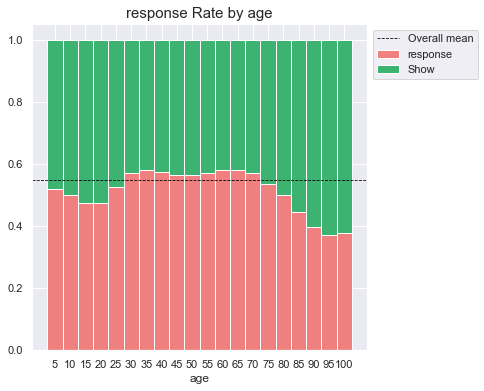

Means test p-value: 0.000
Reject null hypothesis: no-show rate is different for at least one group
Correlation with No-Show: 0.120


In [173]:
df_net = df[(df['net_hour'] < -1) & (df['net_hour'] > -100)]
cat_var(df_net,'age')
print('Correlation with No-Show: %.3f' % ss.pointbiserialr(df['response'], df['net_hour'])[0])
